<h1 style="text-align: center;"> Topic: Marketing Audience Segmentation Using Unsupervised Learning </h1>

In [4]:
#Importing basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Background and Import <a class="anchor" id="section_2"></a>
<p style="text-align: justify;"> 
The data used for this project are from select files used for the Google Customer Revenue Prediction Competition on Kaggle. 

The first dataset involves 903653 observations of visits to Google's Merchandise Store for a period of a year between the 1st of August 2016 to 1st of August 2017. 

The second is another dataset related to this same Google store data, that includes more numerical variables like Sessions, Average Session Duration, Bounce Rate, Transcations and Goal Conversion Rate. This was not part of the original Kaggle competition but it came to be as a result of a "leak" in the competition dataset which sparked some discussion in their forum after which the competition was shut down. https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/68235#401950

The data has been provided by a Kaggle user in corresponding csv files here https://www.kaggle.com/datasets/satian/exported-google-analytics-data?select=Train_external_data_2.csv. We can use this to marge into the first dataset when needed.

</p>



## Data Exploration <a class="anchor" id="section_1"></a>
<p style="text-align: justify;">
According to the instructions from Google on the Kaggle competition, due to formatting issues, IDs like fullVisitorId should be loaded as strings to be properly unique.
</p>

In [5]:
#Loading files with some ID fields as strings
df = pd.read_csv('extracted_fields_train', dtype={'date': str,'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64})
df.shape 

(903653, 30)

The original dataset consists of 903653 observations and 30 features.

In [6]:
#Checking the look of the table, and the variables
df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1.0,1.472830e+09,Chrome,desktop,0.0,...,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1.0,1.472880e+09,Firefox,desktop,0.0,...,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1.0,1.472865e+09,Chrome,desktop,0.0,...,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1.0,1.472881e+09,UC Browser,desktop,0.0,...,1.0,1.0,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2.0,1.472823e+09,Chrome,mobile,1.0,...,NaN,1.0,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google


In [7]:
# Display data types and non-null values
# print(train.info())

#Display summary statistics for numerical variables
#print(df.describe())

## Data Cleaning  <a class="anchor" id="section_1"></a>

<p style="text-align: justify;">
We do some basic exploration first, after checking for duplicate observations, unique values, missing values and some renaming of columns for simplicity.
</p>

In [8]:
## Checking duplicates
duplicates = df.duplicated().sum()
duplicates
#0 so there are no duplicates

0

In [9]:
#Exploring the data types for each variable
#df.dtypes

In [10]:
#Exploring the different categories of channelGrouping
unique_values = df['channelGrouping'].unique()
#print('Unique values:', unique_values)
# They are ['Organic Search' 'Referral' 'Paid Search' 'Affiliates' 'Direct' 'Display''Social' '(Other)']

<p style="text-align: justify;">
Now it is useful to really understand what all these variables mean.

- <strong> channelGrouping </strong>: The channel via which the user came to the Store. Could be one of 'Organic Search' 'Referral' 'Paid Search' 'Affiliates' 'Direct' 'Display' 'Social' or '(Other)'
- <strong> date </strong>: The date of the visit 
- <strong> fullVisitorId </strong>: A unique identifier assigned to each individual user who visits a website.
- <strong> sessionId </strong>: A unique identifier assigned to each user session, which refers to the period between first visit and a set period of inactivity or when the user leaves the website.
- <strong> visitId </strong>:  A unique identifier assigned to each session that is used to distinguish one session from another.
- <strong> visitNumber </strong> :  Count of the number of sessions a user has had on the site. Each time a user starts a new session, visitNumber +1
- <strong> visitStartTime </strong>:  The timestamp (expressed as POSIX time).
- <strong> device.browser, device.deviceCategory, device.isMobile </strong> and <strong> device.operatingSystem </strong>: The details for the device used to access the Store. 54 categories for browser, 3 for deviceCategory (desktop, mobile, tablet), 20 for OS, and 2 for isMobile (1 or 0 binary) 
- <strong> geoNetwork.city, geoNetwork.continent, geoNetwork.country, geoNetwork.metro, geoNetwork.networkDomain, geoNetwork.region, geoNetwork.subContinent </strong>: All information about the geography of the user (649 cities, 6 continents, 222 countries, 94 metros, 28064 network domains, 376 regions, 23 subcontinents
- <strong> totals.bounces</strong> - measures the number of "single-page sessions" (where the user lands on a page and then leaves the website without visiting any other pages)

NOTE: The totals.bounces metric does not take into account the duration of the session. Even if a user spends a significant amount of time on a single page, if they do not visit any other pages on the website or app before leaving, it will still be counted as a bounce.
</p>

<p style="text-align: justify;">
Date seems to be in an object data type. We convert it to datetime format.
</p> 

In [11]:
# Converting date to datetime format.
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [12]:
## Checking missing values
missing_values = df.isnull().sum()
#missing_values

<p style="text-align: justify;">

There are missing values for some of the variables
* trafficSource.adContent - 892707
* trafficSource.isTrueDirect - 629648
* trafficSource.keyword - 502930
* trafficSource.referralPath - 572712

It is normal to expect some missing values for adContent, isTrueDirect, keyword and referralPath.

- adContent may have missing values because not every visitor may arrive after clicking an ad for the Google Merchandise Store.
- isTrueDirect may have missing values because in some cases Google may not be able to know whether a visit was through Direct traffic or not.
- keyword may have missing values because visitors may not be coming to the store after searching for keywords on Google.
- And referralPath may have missing values because the actual referral website URL may not be captured by Google in that particular visit.

</p>

In [13]:
# Filter dataframe based on a value in the categorical variable
filtered_df = df[df['channelGrouping'] == 'Direct']
filtered_df['trafficSource.isTrueDirect'].unique()

array([ 1., nan])

The isTrueDirect variable is a binary categorical one, with just 1 or 0 as the values.

At this stage it is worth doing some cleaning as follows:
* Some of these column names are a bit long and unwieldy so we rename them for simplicity
* Since we have the device category variable, there is no need for the is device.isMobile variable as it is redundant
* Since if channel is not Direct, isTrueDirect will always be false and vice versa, we can drop this too

In [14]:
## Renaming some of the columns with unwieldy names, dropping unnesesary ones and changing the date variable to a datetime format
renamed = df.rename(columns={
    'channelGrouping': 'channel', 
    'fullVisitorId': 'visitorID', 
    'device.browser': 'browser', 
    'device.deviceCategory': 'device', 
    'device.operatingSystem': 'os', 
    'geoNetwork.city': 'city', 
    'geoNetwork.continent': 'continent', 
    'geoNetwork.country': 'country', 
    'geoNetwork.metro': 'metro', 
    'geoNetwork.networkDomain': 'networkDomain', 
    'geoNetwork.region': 'region', 
    'geoNetwork.subContinent': 'subContinent', 
    'totals.bounces': 'bounces', 
    'totals.hits': 'hits', 
    'totals.newVisits': 'newVisits', 
    'totals.pageviews': 'pageviews', 
    'totals.transactionRevenue': 'transactionRevenue',
    'trafficSource.adContent': 'adContent', 
    'trafficSource.campaign': 'campaign', 
    'trafficSource.keyword': 'keyword', 
    'trafficSource.medium': 'medium', 
    'trafficSource.referralPath': 'referralPath', 
    'trafficSource.source': 'source'})

renamed = renamed.drop(['device.isMobile', 'trafficSource.isTrueDirect'],  axis=1)
renamed['date'] = pd.to_datetime(renamed['date'], format='%Y-%m-%d')

<h1> Data Exploration </h1>

Some further exploration using visualizations may be useful to understand the distribution of some of the numerical variables, and also the proportions of observations that fall in different categories of the categorical variables.

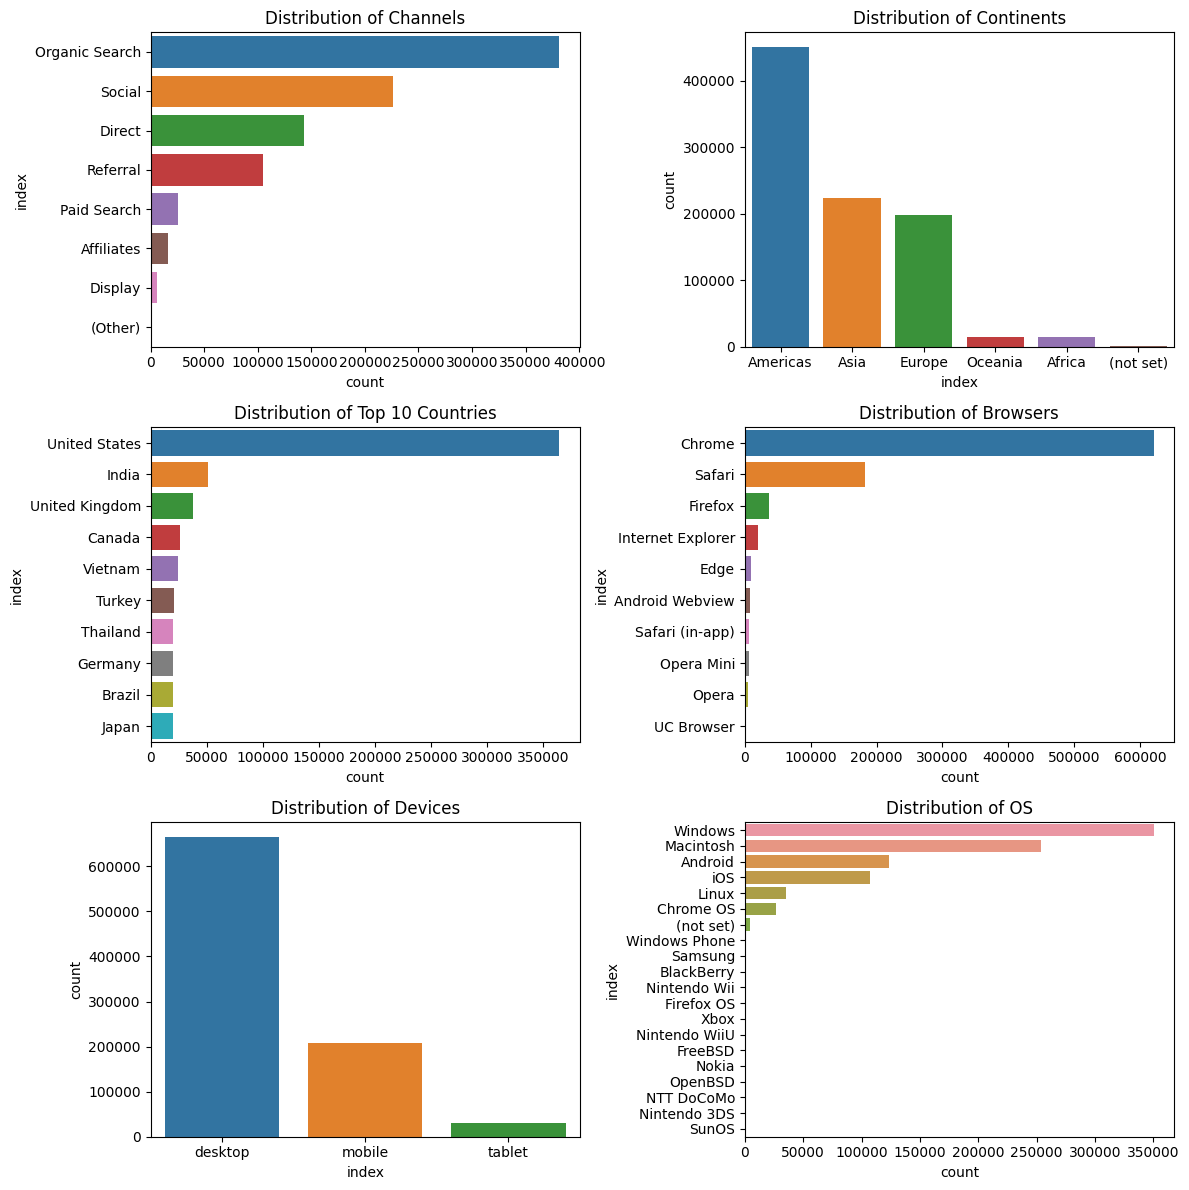

In [15]:
# Visualize the distributions of some of the variables
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Plot 1
sns.barplot(x="count", y="index", data=renamed['channel'].value_counts().reset_index().rename(columns={'channel': 'count', 'index': 'index'}), ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Channels')

# Plot 2
sns.barplot(x="index", y="count", data=renamed['continent'].value_counts().reset_index().rename(columns={'continent': 'count', 'index': 'index'}), ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Continents')

# Plot 3
sns.barplot(x="count", y="index", data=renamed['country'].value_counts().reset_index().rename(columns={'country': 'count', 'index': 'index'}).head(10), ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Top 10 Countries')

# Plot 4 - Browser
sns.barplot(x="count", y="index", data=renamed['browser'].value_counts().reset_index().rename(columns={'browser': 'count', 'index': 'index'}).head(10), ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Browsers')

# Plot 5 - Devices
sns.barplot(x="index", y="count", data=renamed['device'].value_counts().reset_index().rename(columns={'device': 'count', 'index': 'index'}), ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Devices')

# Plot 6 - OS
sns.barplot(x="count", y="index", data=renamed['os'].value_counts().reset_index().rename(columns={'os': 'count', 'index': 'index'}), ax=axes[2, 1])
axes[2, 1].set_title('Distribution of OS')

# axs[1,1].set_title('Visits over time')

# # Remove empty subplots
# for i in range(2, 3):
#     for j in range(1, 2):
#         fig.delaxes(axes[i, j])

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plots
plt.show()


<p style="text-align: justify;">
From these graphs, we can see that: 

- Channels: Google search is the most popular source of visits, followed by Social channels and Direct. Paid search and ads are not a major source.
- Continents: The Americas receive a greater number of visits compared to any other continent, nearly twice as many as Asia and Europe combined. 
- Countries: When considering individual countries, the USA and India attract the highest number of visitors, followed by the UK.
- Browser: Chrome is the most commonly used browser, with Safari being the second most popular choice.
- Device: Most visitors come to the website on a desktop, but there are also a lot of visitors on mobile and a few from tablets as well
- OS: Most visitors are Windows users, then Apple Mac users. Then comes Android users on mobile, followed by iOS users. This may just be useful to get an idea of visitors' "lifestyle choices," such as their preferred operating systems (for example, Mac users versus PC users).

</p>


<p style="text-align: justify;">
We can also visualize the distribution of visitors across the globe through a world map graphic as follows.
</p>

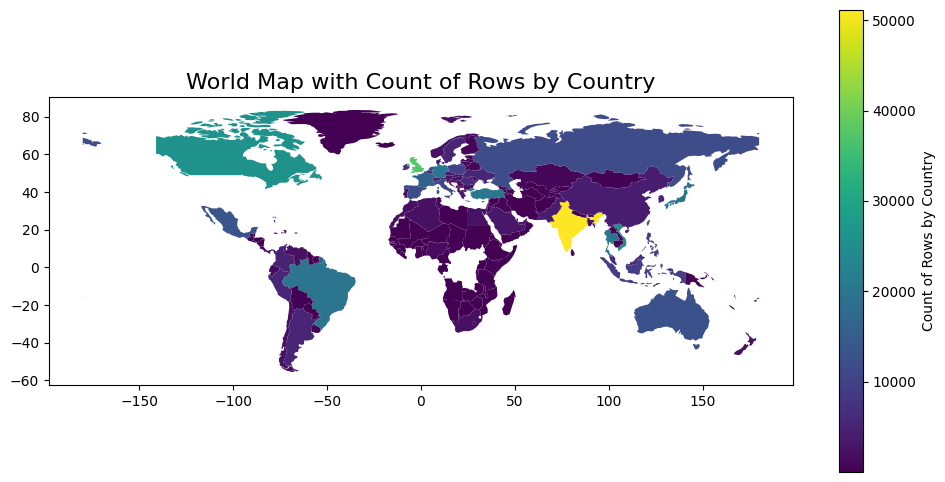

In [16]:
#Visualising the distribution of country
import geopandas as gpd
import matplotlib.pyplot as plt

# group data by country and count the number of rows for each country
counts = renamed.groupby('country').size().reset_index(name='count')

# read world map shapefile into geopandas dataframe
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# merge counts with world map dataframe
merged = world_map.merge(counts, left_on='name', right_on='country', how='left')

# create figure and axis
fig, ax = plt.subplots(figsize=(12,6))

# plot the world map with circles at the coordinates of each country
merged.plot(column='count', ax=ax, legend=True, legend_kwds={'label': "Count of Rows by Country"})

# set plot title
ax.set_title("World Map with Count of Rows by Country", fontsize=16)

# show plot
plt.show()


<p style="text-align: justify;">
And just to get more granular detail on the actual count of visitors from the top few countries, we can group them as below.
</p>

In [17]:
renamed['country'].value_counts().reset_index().rename(columns={'country': 'count', 'index': 'index'}).head(15)


,index,count
0,United States,364744
1,India,51140
2,United Kingdom,37393
3,Canada,25869
4,Vietnam,24598
5,Turkey,20522
6,Thailand,20123
7,Germany,19980
8,Brazil,19783
9,Japan,19731


<p style="text-align: justify;">
Next it is useful to explore how the visits change over time, throughout the year and on a weekly basis to see if there are any patterns we can take advantage of in the eventual clustering.
</p>

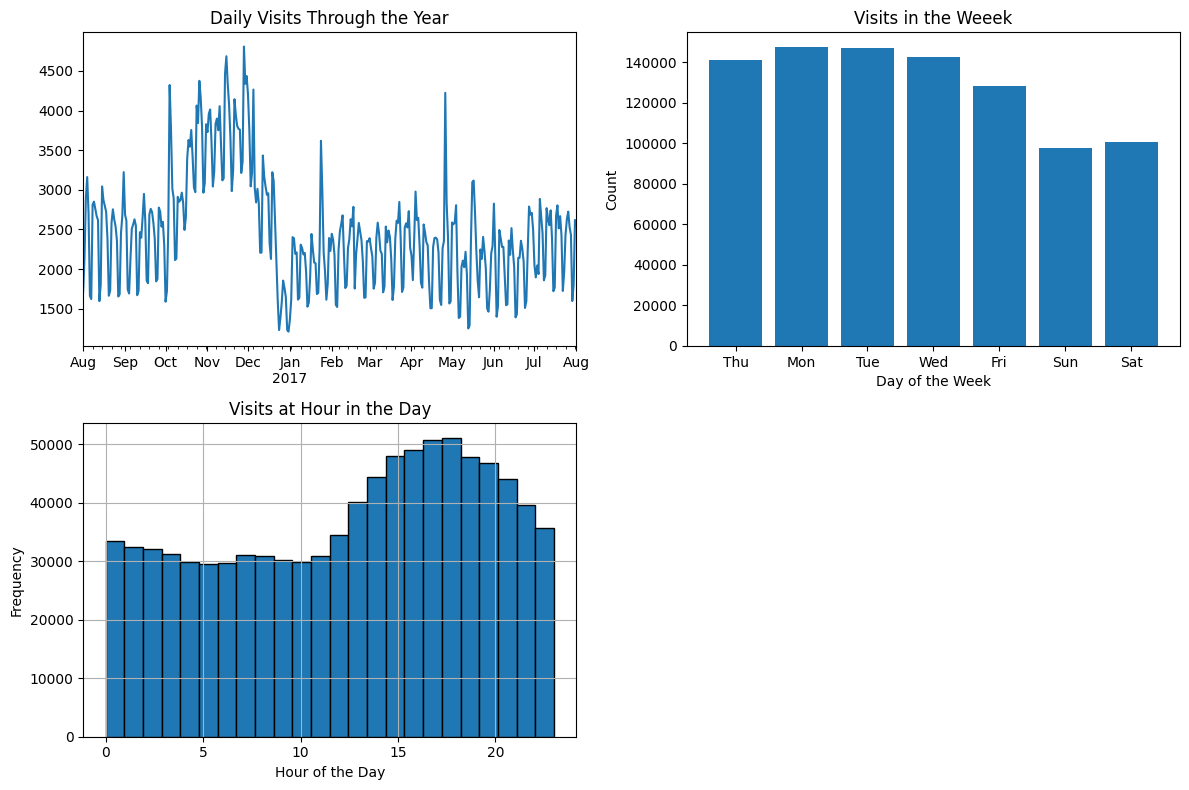

In [18]:
# Visualize the distributions of some of the variables
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1
ax1 = axes[0, 0]
renamed.date.value_counts().sort_index().plot(label="train", ax=ax1)
ax1.set_title('Daily Visits Through the Year')


# Plot 2, for extracting weekday to visualise the observations per day of the Week
ax2 = axes[0, 1]
day_of_week = renamed['date'].dt.dayofweek
day_count = day_of_week.value_counts()
ax2.bar(day_count.index, day_count.values)
ax2.set_xticks(day_count.index)
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax2.set_title('Visits in the Weeek')
ax2.set_xlabel('Day of the Week')
ax2.set_ylabel('Count')

# Plot 3, for extracting the hour of the day they started the sessions from visitStartTime
ax3 = axes[1, 0]
renamed['visitStartTime'] = pd.to_datetime(renamed['visitStartTime'], unit='s')
renamed['Hour'] = renamed['visitStartTime'].dt.hour
renamed['Hour'].hist(bins=24, edgecolor='black', ax=ax3)
ax3.set_xlabel('Hour of the Day')
ax3.set_ylabel('Frequency')
ax3.set_title('Visits at Hour in the Day')

# Remove empty subplot
fig.delaxes(axes[1, 1])

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plots
plt.show()


<p style="text-align: justify;">
As we can see here, the store experienced a higher number of visits during the period from October to January. This can be attributed to the start of the holiday season, as people engage in extensive shopping for themselves or to purchase gifts for others.

Unexpectedly, the number of visits is lower on weekends compared to weekdays.

The timeframe from approximately 11 am to 11 pm appears to be when the store receives the highest number of visitors. However, it is important to note that this observation may not provide a valuable insight due to visitors coming from different time zones. To check how different the visitStartTimes can be in different countries, we can also drill down to the distribution of visits per hour of the day for some of the top countries by visits.
</p> 


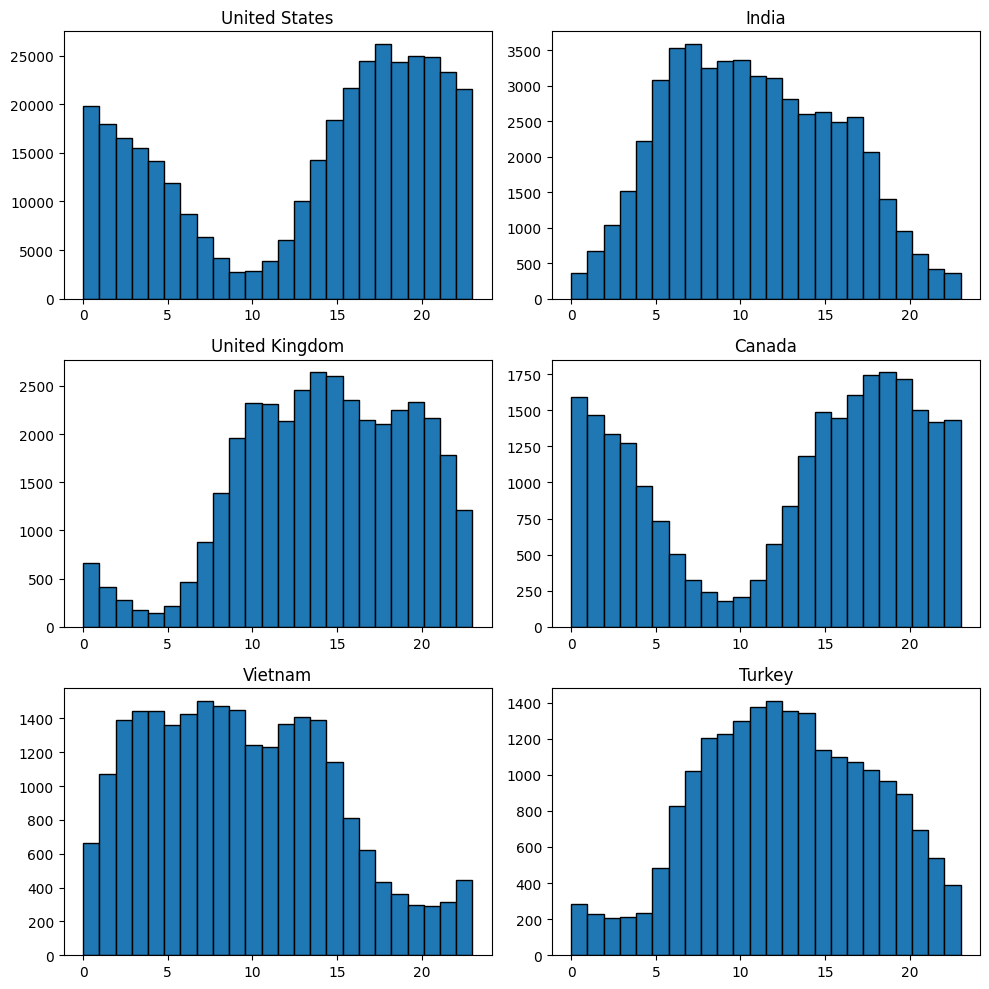

In [19]:
# Define the data for each country
data = {'United States': renamed[renamed['country'] == 'United States']['Hour'],
        'India': renamed[renamed['country'] == 'India']['Hour'],
        'United Kingdom': renamed[renamed['country'] == 'United Kingdom']['Hour'],
        'Canada': renamed[renamed['country'] == 'Canada']['Hour'],
        'Vietnam': renamed[renamed['country'] == 'Vietnam']['Hour'],
        'Turkey': renamed[renamed['country'] == 'Turkey']['Hour']}

# Define the layout of the subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

# Iterate over the countries and plot the histograms in the subplots
for i, (country, hist_data) in enumerate(data.items()):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.hist(hist_data, bins=24, edgecolor='black')
    ax.set_title(country)

plt.tight_layout()
plt.show()

<p style="text-align: justify;">
Upon examining the hours of the day for the top six countries, we can see that peak hours vary among different countries due to different Time Zones. This information could be beneficial for targeted marketing strategies towards specific countries, but not for clustering purposes.
</p>


<p style="text-align: justify;">
Now we look at how the numerical variables are distributed, to see if there is anything more we should keep in mind before clustering.
</p>

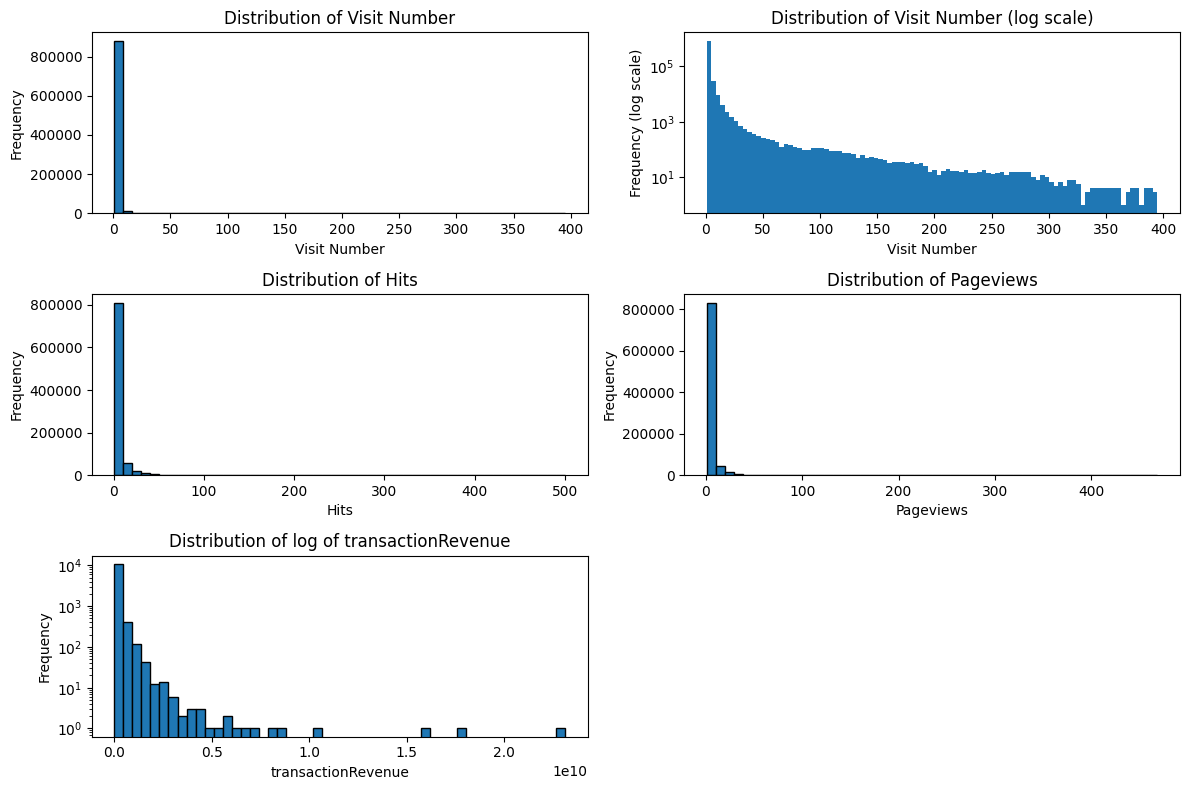

In [20]:
# Create the figure and axes
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Plot 1
ax1 = axes[0, 0]
ax1.hist(renamed['visitNumber'], bins=50, edgecolor='black')
ax1.set_xlabel('Visit Number')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Visit Number')

# Plot 2
ax2 = axes[0, 1]
ax2.hist(renamed['visitNumber'], bins=100, log=True)
ax2.set_xlabel('Visit Number')
ax2.set_ylabel('Frequency (log scale)')
ax2.set_title('Distribution of Visit Number (log scale)')

# Plot 3
ax3 = axes[1, 0]
ax3.hist(renamed['hits'], bins=50, edgecolor='black')
ax3.set_xlabel('Hits')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Hits')

# Plot 4
ax4 = axes[1, 1]
ax4.hist(renamed['pageviews'], bins=50, edgecolor='black')
ax4.set_xlabel('Pageviews')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Pageviews')

# Plot 5
ax4 = axes[2, 0]
ax4.hist(renamed['transactionRevenue'], bins=50, edgecolor='black', log=True)
ax4.set_xlabel('transactionRevenue')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of log of transactionRevenue')

# Remove empty subplot
fig.delaxes(axes[2, 1])

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plots
plt.show()

<p style="text-align: justify;">
These frequency distributions show that 

- Most visitors visit between 0 and 50 times but there are some outlier cases in which visitors come back almost 350 to 400 times
- All these 3 numerical variables exhibit a similar distribution which is skewed to the right, with high values close to 0 to 50 in the case of the first 2 and around 0 to 0.25 e10


</p>

## Data Preprocessing <a class="anchor" id="section_1"></a> 

<p style="text-align: justify;">
We already know that we can drop some of the features. Just to be thorough, we also check for multicollinearity to see if there are any highly correlated variables
</p>


/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_40827/3210827139.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = renamed.corr()


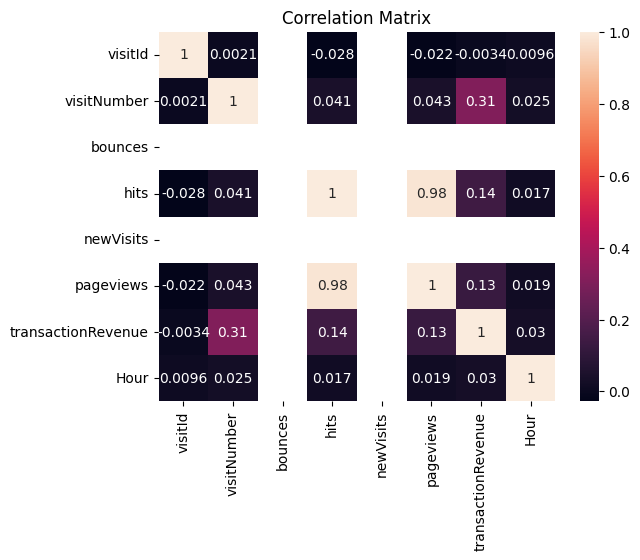

In [21]:
corr_matrix = renamed.corr()

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

<p style="text-align: justify;">

When 2 or more are highly correlated, it can cause issues with model interpretation and stability. We see that hits and pageviews are very highly correlated
Bounces, newVisits and isTrueDirect are binary categorical variables so they don't show up numbers in the above heatmap.

</p>



## Clustering <a class="anchor" id="section_1"></a>

<p style="text-align: justify;">
Pageviews and hits are highly correlated so we have to remove one of them.

Additionally, any kind of IDs don’t mean anything for clustering or any model, so we can drop 'sessionId', 'visitId' ('fullVisitorId' we need to keep for clustering).

Also, since we have the device category variable, there is no need for the is device.isMobile variable as it is redundant. 

And lastly, if channel is not Direct, isTrueDirect will always be false and vice versa (except for nan missing values), we can drop this too.

</p>

<p style="text-align: justify;">
We first try clustering based only on the numerical variables first. So for the first clustering, we will remove all the other variables. 

For clustering we use the k-Means algorithm. This is an unsupervised machine learning algorithm that groups similar data points together based on features. It iteratively assigns each data point to a cluster based on the distance between the data point and the centroid of the cluster. We will specify the number of clusters k beforehand.
</p>

In [22]:
#renamed.columns

In [23]:
firstclust = renamed.drop(['channel','hits', 'date', 'sessionId', 'visitId',
       'visitStartTime', 'browser','bounces', 'newVisits',
       'device', 'os',
       'city', 'continent', 'country',
       'metro', 'networkDomain', 'region',
       'subContinent', 'adContent', 'campaign', 'keyword',
       'medium', 'referralPath',
       'source'], axis=1)

#firstclust

In [24]:
#Converted transactions into log
firstclust['transactionRevenue'] = np.log(firstclust['transactionRevenue'])

<p style="text-align: justify;">
For the kMeans algorithm to work, we cannot have any missing values. To address this we will impute any missing values with the mean. 
</p>

In [25]:
from sklearn.impute import SimpleImputer

# Replace missing values with mean
imputer = SimpleImputer(strategy='mean')
firstclust[['visitNumber', 'pageviews', 'transactionRevenue']] = imputer.fit_transform(firstclust[[ 'visitNumber', 'pageviews', 'transactionRevenue']])

<p style="text-align: justify;">
We also have to standardize the variables before clustering. This controls the variability of the dataset, as it converts data into specific range using a linear transformation which generate good quality clusters and improve the accuracy of clustering algorithms. The idea is that if the different features of the data have different scales, then the gradient-based optimization algorithm that powers the kMeans optimization will involve derivatives that tend to align along directions with higher variance, which leads to poorer/slower convergence.
</p>


In [26]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(firstclust[['visitNumber', 'pageviews', 'transactionRevenue']])

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<p style="text-align: justify;">
The clusters themselves are simply arrays that denote the number of the cluster into which each observation in the dataframe lies in. To understand what exactly each cluster involves, we will have to map them back to the original, unscaled dataset. For this we get the unscaled dataset using inverse transform.
</p>

In [28]:
# Inverse transform to get original data
original_data = scaler.inverse_transform(df_scaled)

In [29]:
original_data

array([[ 1.        ,  1.        , 17.82336226],
       [ 1.        ,  1.        , 17.82336226],
       [ 1.        ,  1.        , 17.82336226],
       ...,
       [ 1.        , 21.        , 17.82336226],
       [ 1.        , 22.        , 17.82336226],
       [ 1.        , 31.        , 17.82336226]])

<p style="text-align: justify;">
To visualize what each of the clusters look like, we have to view the relationship between 2 variables at a time (since we cannot realistically interpret with our visual senses anything that is more than 2-dimensional)
</p>

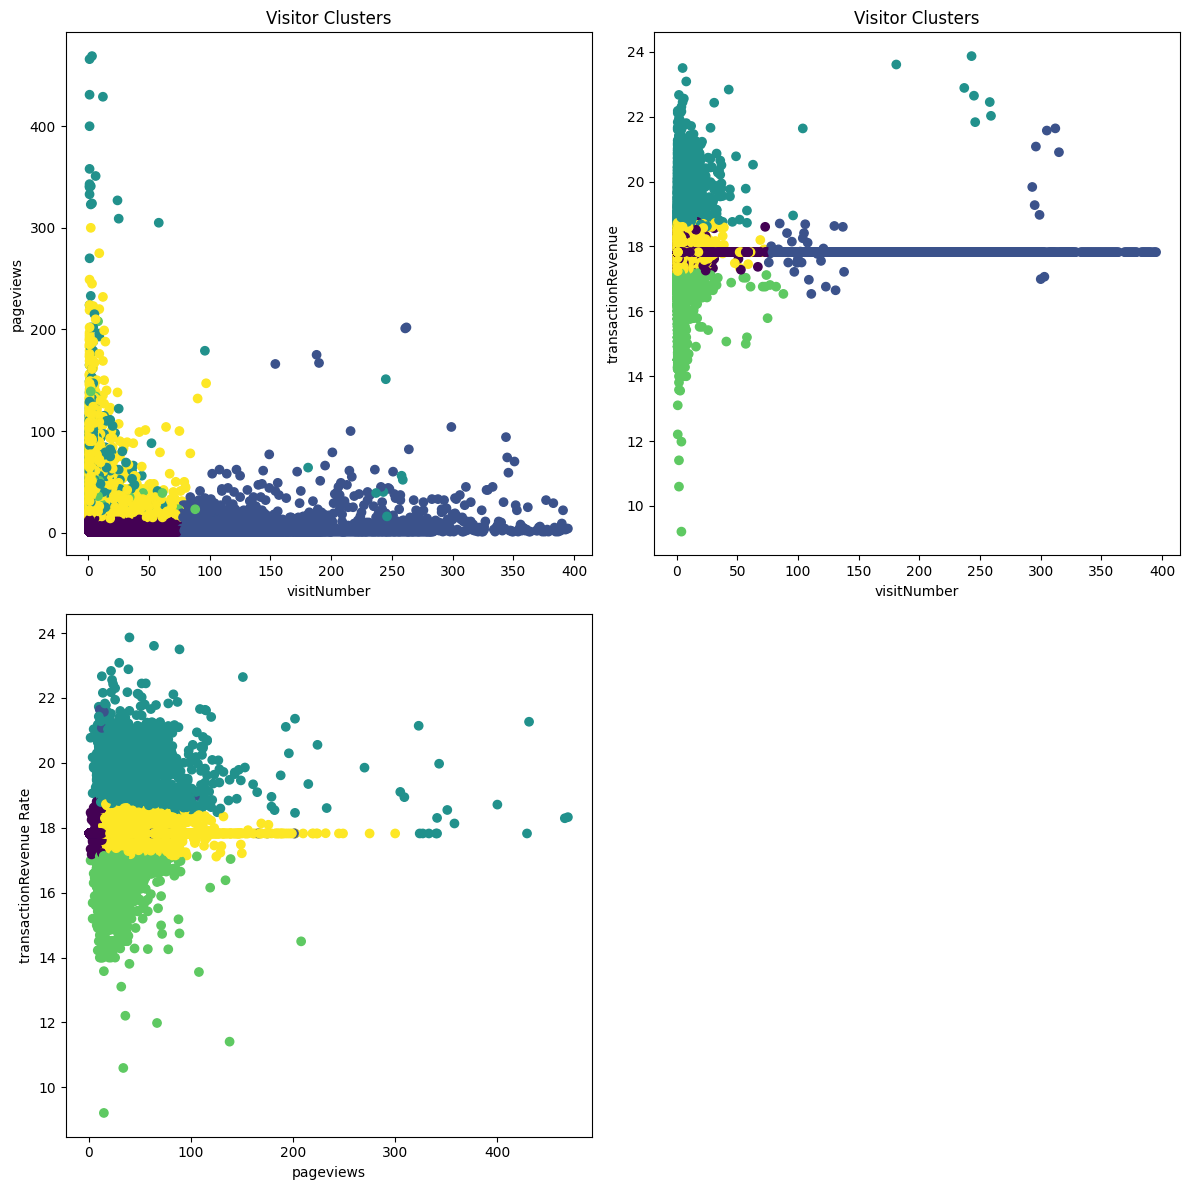

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Plot 1
axs[0, 0].scatter(firstclust['visitNumber'], firstclust['pageviews'],c=clusters)
axs[0, 0].set_xlabel('visitNumber')
axs[0, 0].set_ylabel('pageviews')
axs[0, 0].set_title('Visitor Clusters')

# Plot 2
axs[0, 1].scatter(firstclust['visitNumber'], firstclust['transactionRevenue'],c=clusters)
axs[0, 1].set_xlabel('visitNumber')
axs[0, 1].set_ylabel('transactionRevenue')
axs[0, 1].set_title('Visitor Clusters')

# Plot 3
axs[1, 0].scatter(firstclust['pageviews'], firstclust['transactionRevenue'],c=clusters)
axs[1, 0].set_xlabel('pageviews')
axs[1, 0].set_ylabel('transactionRevenue Rate')

# Remove empty subplot
fig.delaxes(axs[1, 1])

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plots
plt.show()


<p style="text-align: justify;">
What we find is that there are approximately 4 clusters based on visitNumbers, transaction revenue and pageviews.

1.  (Green): Low pageviews, lower transaction revenue, low visitNumbers
    
2.  (Yellow): Low-medium pageviews, low visitNumbers and medium transaction revenue
    
3.  (Dark blue): High visitNumbers, medium transactionRevenue and very few pageViews
    
4.  (Dark green): Low to medium pageviews, High transactionRevenue, high visitNumbers

</p>

## Including more numerical variables <a class="anchor" id="section_1"></a>

<p style="text-align: justify;">
Until now we have been only using 3 numerical variables to find clusters. 
There is another dataset related to this Google store that includes more numerical variables like Sessions, Average Session Duration, Bounce Rate, Transcations and Goal Conversion Rate. 

This was not part of the original Kaggle competition but it came to be as a result of a "leak" in the competition dataset which sparked some discussion in their forum after which the competition was shut down.  https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/68235#401950

The data has been provided by a Kaggle user in corresponding csv files here https://www.kaggle.com/datasets/satian/exported-google-analytics-data?select=Train_external_data_2.csv 

We load and merge these into our data set "renamed which was prepared for feature selection.
</p>

In [33]:
train_store_1 = pd.read_csv('Train_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
train_store_2 = pd.read_csv('Train_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})

In [34]:
#train_store_1.head()

In [35]:
#train_store_2.head()

In [36]:
# print(train_store_1.shape)
# print(train_store_2.shape)

<p style="text-align: justify;">
The way to merge this is through the Client Id but only part of it after the '.' which becomes the same visitID in our original renamed dataset.
</p>


In [37]:
for df in [train_store_1, train_store_2]:
    df["visitId"] = df["Client Id"].apply(lambda x: x.split('.', 1)[1]).astype(np.int64)

In [38]:
merged = renamed.merge(pd.concat([train_store_1, train_store_2], sort=False), how="left", on="visitId")
#merged.head()

We can still drop the categorical variables and other ids as before 

In [39]:
secondclust = merged.drop(['visitorID','channel','hits', 'date', 'sessionId',
       'visitStartTime', 'browser','bounces', 'newVisits',
       'device', 'os',
       'city', 'continent', 'country',
       'metro', 'networkDomain', 'region',
       'subContinent', 'adContent', 'campaign', 'keyword',
       'medium', 'referralPath',
       'source','Revenue','Hour','Client Id'], axis=1)

#secondclust

In [40]:
secondclust.shape

(903654, 9)

In [41]:
secondclust.dtypes

visitId                    int64
visitNumber              float64
pageviews                float64
transactionRevenue       float64
Sessions                 float64
Avg. Session Duration     object
Bounce Rate               object
Transactions             float64
Goal Conversion Rate      object
dtype: object

<p style="text-align: justify;">
We still need to log transform transactionRevenue, convert Avg.Session Duration to seconds and also remove the % symbols from Bounce Rate and Goal Conversion Rate
</p>

In [42]:
#Converted transactions into log
secondclust['transactionRevenue'] = np.log(secondclust['transactionRevenue'])

<p style="text-align: justify;">
In this clustering attempt, we assign the Avg. Session Duration to be 0 if it is missing.
</p>

In [43]:
secondclust['Avg. Session Duration'] = secondclust['Avg. Session Duration'].apply(lambda x: 0 if isinstance(x, float) else sum(int(i) * 60 ** j for j, i in enumerate(x.split(":")[::-1])))

In [44]:
secondclust["Bounce Rate"] = secondclust["Bounce Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)
secondclust["Goal Conversion Rate"] = secondclust["Goal Conversion Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)
secondclust = secondclust.loc[secondclust['Avg. Session Duration'] != 0]
#secondclust.sort_values(by='Avg. Session Duration', ascending=False)

In [45]:
# Replace missing values with mean
imputer2 = SimpleImputer(strategy='mean')
secondclust[['visitNumber','pageviews','transactionRevenue','Sessions','Avg. Session Duration','Bounce Rate','Transactions','Goal Conversion Rate']] = imputer2.fit_transform(secondclust[['visitNumber','pageviews','transactionRevenue','Sessions','Avg. Session Duration','Bounce Rate','Transactions','Goal Conversion Rate']])


In [46]:
scaler2 = StandardScaler()
df2_scaled = scaler2.fit_transform(secondclust[['visitNumber','pageviews','transactionRevenue','Sessions','Avg. Session Duration','Bounce Rate','Transactions','Goal Conversion Rate']])
#df2_scaled

In [47]:
kmeans2 = KMeans(n_clusters=5, random_state=42)
clusters2 = kmeans.fit_predict(df2_scaled)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [48]:
# Inverse transform to get original data
original_data2 = scaler2.inverse_transform(df2_scaled)


<p style="text-align: justify;">
Just like before we visualize the relation between 2 variables at a time in each of the clusters through the scatterplot.
</p>


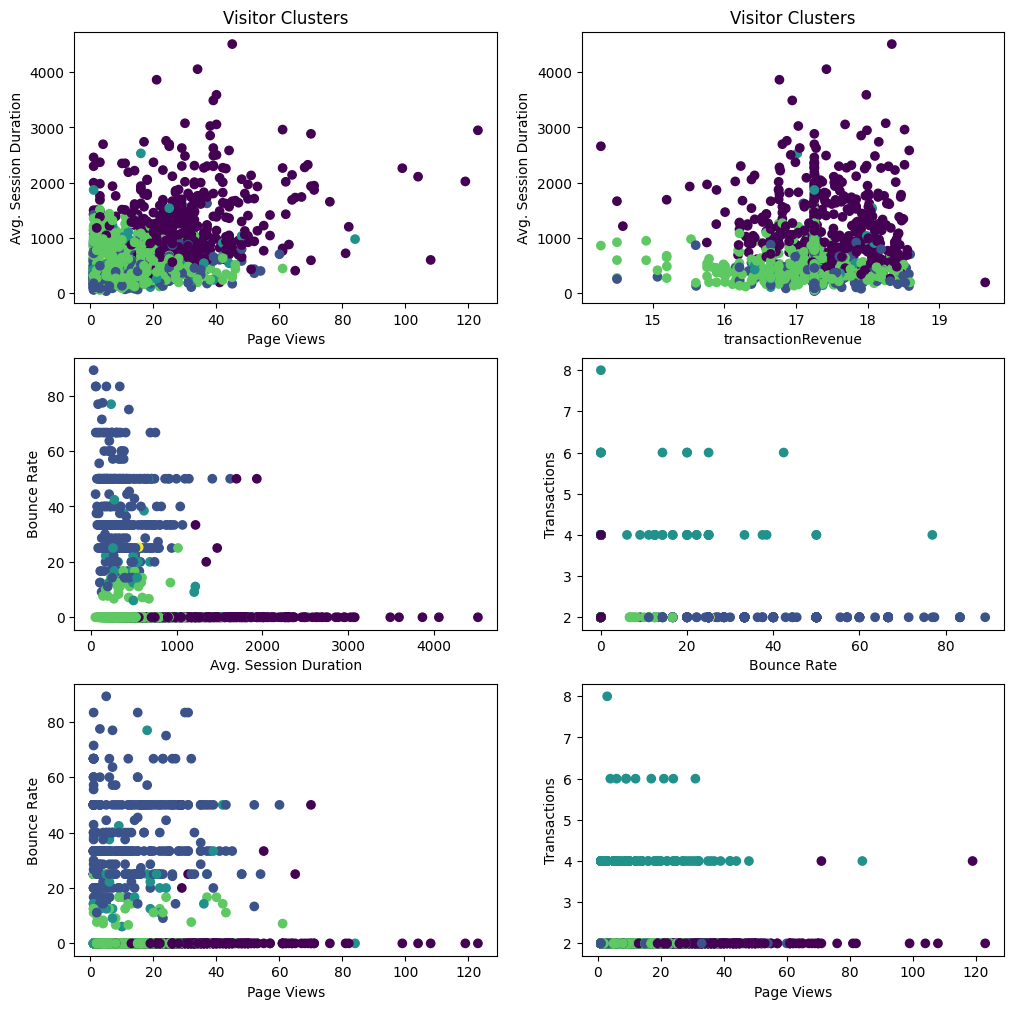

In [49]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Plot 1
axs[0, 0].scatter(original_data2[:, 1], original_data2[:, 4], c=clusters2)
axs[0, 0].set_xlabel('Page Views')
axs[0, 0].set_ylabel('Avg. Session Duration')
axs[0, 0].set_title('Visitor Clusters')

# Plot 2
axs[0, 1].scatter(original_data2[:, 2], original_data2[:, 4], c=clusters2)
axs[0, 1].set_xlabel('transactionRevenue')
axs[0, 1].set_ylabel('Avg. Session Duration')
axs[0, 1].set_title('Visitor Clusters')

# Plot 3
axs[1, 0].scatter(original_data2[:, 4], original_data2[:, 5], c=clusters2)
axs[1, 0].set_xlabel('Avg. Session Duration')
axs[1, 0].set_ylabel('Bounce Rate')

# Plot 4
axs[1, 1].scatter(original_data2[:, 5], original_data2[:, 6], c=clusters2)
axs[1, 1].set_xlabel('Bounce Rate')
axs[1, 1].set_ylabel('Transactions')

# Plot 5
axs[2, 0].scatter(original_data2[:, 1], original_data2[:, 5], c=clusters2)
axs[2, 0].set_xlabel('Page Views')
axs[2, 0].set_ylabel('Bounce Rate')

# Plot 6
axs[2, 1].scatter(original_data2[:, 1], original_data2[:, 6], c=clusters2)
axs[2, 1].set_xlabel('Page Views')
axs[2, 1].set_ylabel('Transactions')

plt.show()


<p style="text-align: justify;">
Based on the results of this clustering, we could say there are 3 clear clusters, dark purple, green and dark blue 

1. (Green): Low pageviews,  low session duration,  low BounceRate, few transactions
2. (Dark blue): Low session duration, few transactions, low to medium pageviews
3. (Purple): Low to medium page views, low bounce rate, medium to high transaction revenue, generally high session duration


NOTE: Replacing the NaN values of Avg. Session Duration with 0 may not make sense. For example, some of these visits with NaN durations have high transactionRevenue and PageViews. So a simpler option is to remove these NaN rows altogether first.
</p>

<p style="text-align: justify;">
Now we include the categorical variables as well, and see what the clusters look like.
</p>


## Including Categorical Variables <a class="anchor" id="section_1"></a>

<p style="text-align: justify;">
We first select the dataframe for clustering with the necessary variables. This includes the numerical variables we previously selected, and new categorical variables. But we don't want to select all categorical variables as some may have too many categories, like cities or metros.
</p>


In [50]:
merged.nunique()

channel                       8
date                        366
visitorID                714167
sessionId                902755
visitId                  886303
visitNumber                 384
visitStartTime           887159
browser                      54
device                        3
os                           20
city                        649
continent                     6
country                     222
metro                        94
networkDomain             28064
region                      376
subContinent                 23
bounces                       1
hits                        274
newVisits                     1
pageviews                   213
transactionRevenue         5332
adContent                    44
campaign                     10
keyword                    3658
medium                        7
referralPath               1475
source                      380
Hour                         24
Client Id                  1744
Sessions                     22
Avg. Ses

<p style="text-align: justify;">
Let's only choose channel', 'browser', 'device','os', 'continent', 'campaign' as these have manageable categories.
</p>


In [51]:
fourthclust = merged.drop(['visitorID','hits', 'date', 'sessionId',
       'visitStartTime','bounces', 'newVisits',
       'city', 'country',
       'metro', 'networkDomain', 'region',
       'subContinent', 'adContent', 'keyword',
       'medium', 'referralPath',
       'source','Revenue','Hour','Client Id'], axis=1)


#fourthclust

In [52]:
# Convert categorical variables to binary features using one-hot encoding
ohe = OneHotEncoder(sparse=False)
cat_vars = ['channel', 'browser','device', 'os','continent','campaign']
cat_data = ohe.fit_transform(fourthclust[cat_vars])
cat_df = pd.DataFrame(cat_data, columns=ohe.get_feature_names_out(cat_vars))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [53]:
numandcat = pd.concat([fourthclust, cat_df], axis=1)
#numandcat

In [54]:
catclust = numandcat.drop(cat_vars, axis=1) #Removing the original categorical variables
#catclust

In [55]:
#Dropping the NaN values
catclusttemp = catclust.dropna()
#catclusttemp

In [56]:
#Now cleaning the same numerical variables
catclusttemp['Avg. Session Duration'] = catclusttemp['Avg. Session Duration'].apply(lambda x: sum(int(i) * 60 ** j for j, i in enumerate(x.split(":")[::-1])))
catclusttemp["Bounce Rate"] = catclusttemp["Bounce Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)
catclusttemp["Goal Conversion Rate"] = catclusttemp["Goal Conversion Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)

/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_40827/2848027170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catclusttemp['Avg. Session Duration'] = catclusttemp['Avg. Session Duration'].apply(lambda x: sum(int(i) * 60 ** j for j, i in enumerate(x.split(":")[::-1])))
/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_40827/2848027170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catclusttemp["Bounce Rate"] = catclusttemp["Bounce Rate"].astype(str).apply(lambda x: x.replace('

In [57]:
# Log transform the 'totals.transactionRevenue' column
catclusttemp['transactionRevenue'] = np.log(catclusttemp['transactionRevenue'])

/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_40827/53769737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catclusttemp['transactionRevenue'] = np.log(catclusttemp['transactionRevenue'])


<p style="text-align: justify;">
Now we have to scale the numerical variables again. Remember that we only scale the numerical ones, we leave the categorical encoded ones since they are already 1 and 0.
</p>


In [58]:
# Scale all the numerical variables
scaler = StandardScaler()
df4_scaled = scaler.fit_transform(catclusttemp[['visitNumber','pageviews','transactionRevenue','Sessions','Avg. Session Duration','Bounce Rate','Transactions','Goal Conversion Rate']])


In [59]:
catencoded = catclusttemp.drop(['visitId','visitNumber','pageviews','transactionRevenue','Sessions','Avg. Session Duration','Bounce Rate','Transactions','Goal Conversion Rate'], axis=1)
#catencoded


In [60]:
#A minor matter of converting the df4_scaled scaled numericals into a dataframe, as they were an array during the scaling process.
num_vars_scaled = pd.DataFrame(df4_scaled, columns=['visitNumber','totals.pageviews','totals.transactionRevenue','Sessions','Avg. Session Duration','Bounce Rate','Transactions','Goal Conversion Rate'], index=catclusttemp.index)
#num_vars_scaled

In [61]:
dataframe = pd.concat([catencoded, num_vars_scaled], axis=1)
#dataframe

In [62]:
# Now finally perform kmeans clustering
kmeans = KMeans(n_clusters=6, random_state=42)
clusters4 = kmeans.fit_predict(dataframe)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<p style="text-align: justify;">
To visualise the distribution of the categorical variables in each of the clusters, we have to first attach the clusters to the dataset with the original categorical variables.
</p>


In [63]:
final_og_df = numandcat.dropna()
final_og_df['Cluster'] = clusters4
#final_og_df

/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_40827/552899092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_og_df['Cluster'] = clusters4


In [71]:
forcatviz = final_og_df[['channel','browser','device','os','continent','campaign','Cluster']]

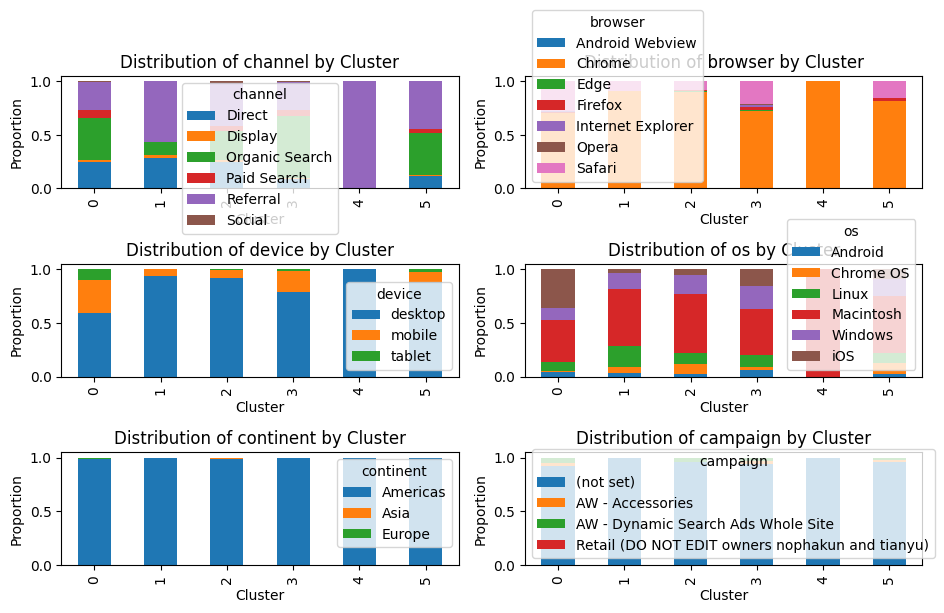

In [73]:
# Create the figure and axes
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

# Plot 1
ax1 = axes[0, 0]
ct1 = pd.crosstab(forcatviz['Cluster'], forcatviz['channel'], normalize='index')
ct1.plot(kind='bar', stacked=True, figsize=(10, 6), ax=ax1)
ax1.set_title("Distribution of channel by Cluster")
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Proportion')

# Plot 2
ax2 = axes[0, 1]
ct2 = pd.crosstab(forcatviz['Cluster'], forcatviz['browser'], normalize='index')
ct2.plot(kind='bar', stacked=True, figsize=(10, 6), ax=ax2)
ax2.set_title("Distribution of browser by Cluster")
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Proportion')

# Plot 3
ax3 = axes[1, 0]
ct3 = pd.crosstab(forcatviz['Cluster'], forcatviz['device'], normalize='index')
ct3.plot(kind='bar', stacked=True, figsize=(10, 6), ax=ax3)
ax3.set_title("Distribution of device by Cluster")
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Proportion')

# Plot 4
ax4 = axes[1, 1]
ct4 = pd.crosstab(forcatviz['Cluster'], forcatviz['os'], normalize='index')
ct4.plot(kind='bar', stacked=True, figsize=(10, 6), ax=ax4)
ax4.set_title("Distribution of os by Cluster")
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Proportion')

# Plot 5
ax5 = axes[2, 0]
ct5 = pd.crosstab(forcatviz['Cluster'], forcatviz['continent'], normalize='index')
ct5.plot(kind='bar', stacked=True, figsize=(10, 6), ax=ax5)
ax5.set_title("Distribution of continent by Cluster")
ax5.set_xlabel('Cluster')
ax5.set_ylabel('Proportion')

# Plot 6
ax6 = axes[2, 1]
ct6 = pd.crosstab(forcatviz['Cluster'], forcatviz['campaign'], normalize='index')
ct6.plot(kind='bar', stacked=True, figsize=(10, 6), ax=ax6)
ax6.set_title("Distribution of campaign by Cluster")
ax6.set_xlabel('Cluster')
ax6.set_ylabel('Proportion')

# # Remove empty subplot
# fig.delaxes(axes[3, 1])

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plots
plt.show()

<p style="text-align: justify;">

Visualising the distribution of categorical variables in each cluster
- Cluster 4 seems to be exclusively Mac users who click on external links to the Google Store, on Chrome browsers in their desktops
- Cluster 0 has the most mobile visitors, Safari users and on an iPhone
- Cluster 3 has the most Android phone visitors, the most organic search visitors and also the most Windows users
- Cluster 1 has the most Linux users, Direct visits, some mobile users and some Safari users


</p>

In [74]:
#print(final_og_df.columns)

In [75]:
#final_og_df[['visitNumber','pageviews','transactionRevenue']]

In [76]:
catclusttemp['Cluster'] = clusters4

/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_40827/1520450296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catclusttemp['Cluster'] = clusters4


Text(0, 0.5, 'Transactions')

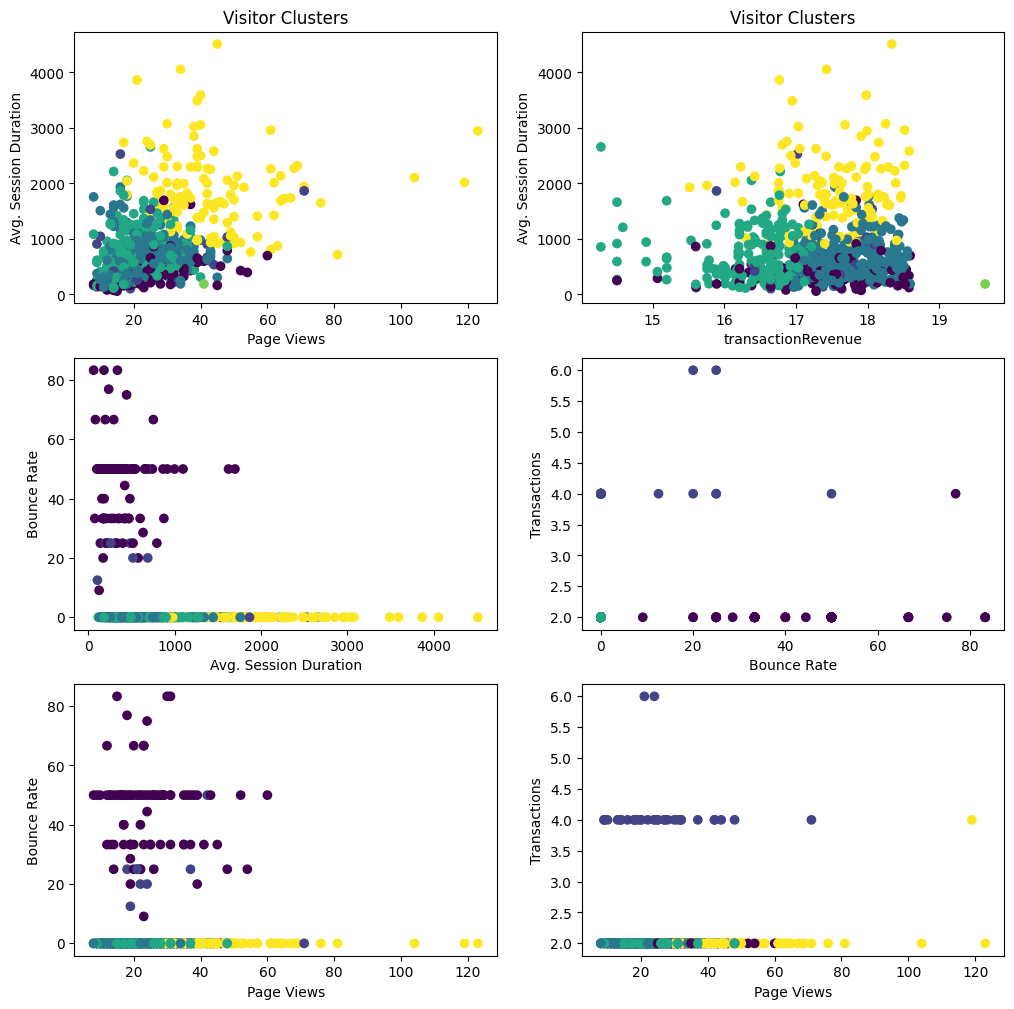

In [77]:
# Visualize the clusters on the original_data, 2 numerical variables at a time
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Plot 1
axs[0, 0].scatter(catclusttemp['pageviews'], catclusttemp['Avg. Session Duration'], c=catclusttemp['Cluster'])
axs[0, 0].set_xlabel('Page Views')
axs[0, 0].set_ylabel('Avg. Session Duration')
axs[0, 0].set_title('Visitor Clusters')

# Plot 2
axs[0, 1].scatter(catclusttemp['transactionRevenue'], catclusttemp['Avg. Session Duration'], c=catclusttemp['Cluster'])
axs[0, 1].set_xlabel('transactionRevenue')
axs[0, 1].set_ylabel('Avg. Session Duration')
axs[0, 1].set_title('Visitor Clusters')

# Plot 3
axs[1, 0].scatter(catclusttemp['Avg. Session Duration'], catclusttemp['Bounce Rate'], c=catclusttemp['Cluster'])
axs[1, 0].set_xlabel('Avg. Session Duration')
axs[1, 0].set_ylabel('Bounce Rate')


# Plot 4
axs[1, 1].scatter(catclusttemp['Bounce Rate'], catclusttemp['Transactions'], c=catclusttemp['Cluster'])
axs[1, 1].set_xlabel('Bounce Rate')
axs[1, 1].set_ylabel('Transactions')


# Plot 5
axs[2, 0].scatter(catclusttemp['pageviews'], catclusttemp['Bounce Rate'], c=catclusttemp['Cluster'])
axs[2, 0].set_xlabel('Page Views')
axs[2, 0].set_ylabel('Bounce Rate')


# Plot 6
axs[2, 1].scatter(catclusttemp['pageviews'], catclusttemp['Transactions'], c=catclusttemp['Cluster'])
axs[2, 1].set_xlabel('Page Views')
axs[2, 1].set_ylabel('Transactions')


<p style="text-align: justify;">
Numerical variables in each cluster

1. (Green): Low pageviews,  lower Avg. Session Duration, low Bounce rate low-medium transactionRevenue
2. (Yellow): Medium pageviews, Avg.Session Duration, medium-high transaction revenue, low bounce rate
3. (Purple): Low pageviews and session duration, medium to high transactionRevenue and high bounce rate 
4. (Dark green): Not very clear, coincides with others in these 2 dimensional visualisations
</p>


